#### Bitcoin1

Areas of focus:

1. Moving Averages 
2. Movement Above and Below Moving Averages 
3. Typical Highs and Lows in Different Timeframes 
4. Demonstration of How Volatility has Changed Over Time (Decreased?)

Tactics might include:

1. waiting for bottoms to be confirmed and selling in the money, or at the money, puts
2. waiting for drops of X% over a time period of Y as an indication to sell puts 

#### DataFrame Setup

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import pandas_datareader as pdr 
import time 
import datetime as dt 
from pycoingecko import CoinGeckoAPI 
cg = CoinGeckoAPI()

In [2]:
start = dt.datetime(2014,1,1)
end = dt.datetime.now() 
btc = pdr.DataReader('BTC-USD', 'yahoo', start, end) 
btc.reset_index(level=0, inplace=True) 

In [3]:
start = dt.datetime(2014,1,1)
end = dt.datetime.now() 
btc = pdr.DataReader('BTC-USD', 'yahoo', start, end) 
btc.reset_index(level=0, inplace=True) 

additionals1 = pd.DataFrame([[dt.datetime(2020,4,17), 7175.0, 7100.0, 7125.0, 7150.0, 32000000000, 7155.0], 
                            [dt.datetime(2020,10,9), 11200.0, 10800.0, 11000.0, 11100.0, 22000000000, 11500.0], 
                            [dt.datetime(2020,10,12), 11450.0, 11250.0, 11375.0, 11400.0, 23000000000, 11410.0],
                            [dt.datetime(2020,10,13), 11500.0, 11300.0, 11400.0, 11450.0, 24000000000, 11460.0]], 
                            columns=btc.columns)


btc = btc.append(additionals1)

btc.drop_duplicates(subset='Date', keep='first', inplace=True)

btc.shape 

(2630, 7)

#### use the following website for yesterday's data: 

https://coincodex.com/crypto/bitcoin/historical-data/

In [4]:
"""yesterday = dt.datetime(2021, 9, 9) 

yesterday_open = 46051
yesterday_high = 47214
yesterday_low = 45639
yesterday_close = 46320 
yesterday_adj_close = yesterday_close 
yesterday_volume = 67000000000

btc_yesterday = pd.DataFrame([[yesterday, yesterday_high, yesterday_low, yesterday_open, yesterday_close, 
                 yesterday_volume, yesterday_adj_close]], columns=btc.columns)

btc = btc.append(btc_yesterday)"""

btc = btc.sort_values(by='Date')
btc['Count'] = np.arange(btc.shape[0])

In [5]:
btc['date_diff'] = btc.Date - btc.Date.shift(1)
print(btc.date_diff.value_counts())
btc.drop('date_diff', axis=1, inplace=True)

1 days    2629
Name: date_diff, dtype: int64


#### Percent Change Columns

In [6]:
btc['one_day_perc_chng'] = (btc.Close - btc.Close.shift(1)) / btc.Close.shift(1)
btc['ten_day_perc_chng'] = (btc.Close - btc.Close.shift(10)) / btc.Close.shift(10)
btc['twenty_day_perc_chng'] = (btc.Close - btc.Close.shift(20)) / btc.Close.shift(20)
btc['twenty_day_quartile'] = pd.qcut(btc.twenty_day_perc_chng, 4, labels=['large_drop', 'small_drop', 
                                                                          'small_gain', 'large_gain'])

btc['twenty_day_perc_chng_abs'] = abs(btc['twenty_day_perc_chng'])
btc['twenty_day_rank_abs'] = btc.twenty_day_perc_chng_abs.rank(pct=True)

btc['six_month_perc_chng'] = (btc.Close - btc.Close.shift(180)) / btc.Close.shift(180)

btc.drop('twenty_day_perc_chng_abs', axis=1, inplace=True)

#### Moving Average Columns

In [7]:
btc['rolling_10_day_avg'] = btc.Close.rolling(window=10, min_periods=1).mean()
btc['rolling_50_day_avg'] = btc.Close.rolling(window=50, min_periods=1).mean()
btc['rolling_180_day_avg'] = btc.Close.rolling(window=180, min_periods=1).mean()

btc['EMA_10_day'] = btc.Close.ewm(span=10).mean()
btc['EMA_50_day'] = btc.Close.ewm(span=50).mean()
btc['EMA_180_day'] = btc.Close.ewm(span=180).mean()

btc['dist_10_day_EMA'] = (btc['Close'] - btc['EMA_10_day']) / btc['EMA_10_day']
btc['dist_10_day_EMA_abs'] = abs(btc.dist_10_day_EMA)
btc['dist_10_day_rank'] = btc.dist_10_day_EMA.rank(pct=True)
btc['dist_10_day_rank_abs'] = btc.dist_10_day_EMA_abs.rank(pct=True)

btc['dist_50_day_EMA'] = (btc['Close'] - btc['EMA_50_day']) / btc['EMA_50_day'] 
btc['dist_50_day_EMA_abs'] = abs(btc.dist_50_day_EMA) 
btc['dist_50_day_rank'] = btc.dist_50_day_EMA.rank(pct=True) 
btc['dist_50_day_rank_abs'] = btc.dist_50_day_EMA_abs.rank(pct=True) 

btc['dist_180_day_EMA'] = (btc['Close'] - btc['EMA_180_day']) / btc['EMA_180_day'] 

btc.drop(['dist_10_day_EMA_abs', 'dist_50_day_EMA_abs'], axis=1, inplace=True)

#### Distance From 52-week High and Low

In [8]:
btc['fifty_two_wk_high'] = btc.Close.rolling(window=365, min_periods=1).max()
btc['dist52_wk_high'] = (btc.fifty_two_wk_high - btc.Close) / btc.fifty_two_wk_high

btc['fifty_two_wk_low'] = btc.Close.rolling(window=365, min_periods=1).min()
btc['dist52_wk_low'] = (btc.Close - btc.fifty_two_wk_low) / btc.fifty_two_wk_low 

#### Forward Pricing

In [9]:
btc['twenty_day_fwd_perc_chng'] = (btc.Close.shift(-20) - btc.Close) / btc.Close 
btc['twenty_day_fwd_quartile'] = pd.qcut(btc.twenty_day_fwd_perc_chng, 4, 
                                         labels=['large_drop', 'small_drop', 'small_gain', 'large_gain'])

btc['thirty_day_fwd_perc_chng'] = (btc.Close.shift(-30) - btc.Close) / btc.Close 
btc['thirty_day_fwd_quartile'] = pd.qcut(btc.thirty_day_fwd_perc_chng, 4, 
                                         labels=['large_drop', 'small_drop', 'small_gain', 'large_gain'])

btc['six_month_fwd_perc_chng'] = (btc.Close.shift(-180) - btc.Close) / btc.Close
btc['six_month_fwd_quartile'] = pd.qcut(btc.six_month_fwd_perc_chng, 4, 
                                         labels=['large_drop', 'small_drop', 'small_gain', 'large_gain'])

#### Volatility

In [10]:
btc['log_returns'] = np.log(btc.Close / btc.Close.shift(1))
btc['VolAnnual'] = btc.log_returns.rolling(window=btc.shape[0], min_periods=1).std()*(365**(1/2))
btc['VolAnnualPercentile'] = btc.VolAnnual.rank(pct=True)

btc['Vol30day'] = btc.log_returns.rolling(window=30, min_periods=1).std()*(30**(1/2))
btc['Vol30dayPercentile'] = btc.Vol30day.rank(pct=True)

btc['Vol10day'] = btc.log_returns.rolling(window=10, min_periods=1).std()*(10**(1/2))
btc['Vol10dayPercentile'] = btc.Vol10day.rank(pct=True)

btc.drop('log_returns', axis=1, inplace=True)

In [11]:
high_ten_day = btc[btc.dist_10_day_rank > .99]

In [12]:
high_ten_day_vol = btc[btc.Vol10dayPercentile > .90]
high_ten_day_vol['twenty_day_quartile'].value_counts()

large_drop    141
large_gain     61
small_gain     36
small_drop     23
Name: twenty_day_quartile, dtype: int64

In [13]:
mid_may = btc.loc[(btc.Date > '2021-08-10') & (btc.Date < '2021-08-16')]
mid_may 

,Date,High,Low,Open,Close,Volume,Adj Close,Count,one_day_perc_chng,ten_day_perc_chng,...,thirty_day_fwd_perc_chng,thirty_day_fwd_quartile,six_month_fwd_perc_chng,six_month_fwd_quartile,VolAnnual,VolAnnualPercentile,Vol30day,Vol30dayPercentile,Vol10day,Vol10dayPercentile
2516,2021-08-11,46735.632812,45351.710938,45599.703125,45593.636719,3.431971e+10,45593.636719,2520,0.000189,0.140557,...,-0.015566,small_drop,NaN,NaN,0.755079,0.785769,0.178030,0.477549,0.102290,0.552131
2517,2021-08-12,46228.910156,43861.445312,45576.878906,44428.289062,3.372362e+10,44428.289062,2521,-0.025559,0.133318,...,0.017403,small_drop,NaN,NaN,0.755003,0.784247,0.180146,0.489726,0.104719,0.569635
2518,2021-08-13,47831.976562,44282.417969,44439.691406,47793.320312,3.174426e+10,47793.320312,2522,0.075741,0.252676,...,-0.036199,small_drop,NaN,NaN,0.755339,0.790335,0.190583,0.548706,0.110329,0.609209
2519,2021-08-14,48098.683594,46177.632812,47810.687500,47096.945312,3.121135e+10,47096.945312,2523,-0.014571,0.184903,...,-0.045308,small_drop,NaN,NaN,0.755215,0.787671,0.187090,0.525875,0.113974,0.630518
2520,2021-08-15,47357.105469,45579.589844,47096.667969,47047.003906,3.098896e+10,47047.003906,2524,-0.001060,0.151150,...,0.000967,small_drop,NaN,NaN,0.755066,0.785388,0.185976,0.520548,0.114573,0.635084


In [14]:
near_low = btc[btc.dist52_wk_low < .25]
near_low['six_month_fwd_quartile'].value_counts()

large_drop    130
large_gain    112
small_drop     40
small_gain     14
Name: six_month_fwd_quartile, dtype: int64

### potential scoring could include:

1. 10-day volatility

2. previous 10 or 20 day price change, note: need to distinguish between increases and declines 

3. distance from 10 or 50 da MA 


### then need to compare that to simply using distance below the 10 day (percentile ranking)

#### SIX-MONTH CHART - CURRENT

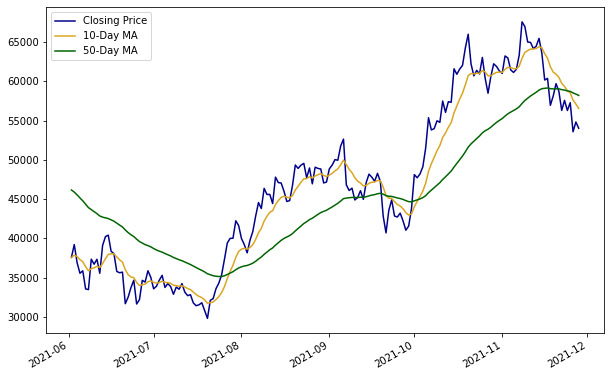

In [15]:
fig, ax = plt.subplots(figsize=(10, 6)) 

cutoff_date1 = dt.datetime.today() - dt.timedelta(days=180) 
last_180_days = btc[btc.Date >= cutoff_date1] 

plt.xticks(rotation=30, ha="right") 

ax.plot(last_180_days.Date, last_180_days.Close, color='darkblue', label='Closing Price')
ax.plot(last_180_days.Date, last_180_days.EMA_10_day, color='goldenrod', label='10-Day MA') 
ax.plot(last_180_days.Date, last_180_days.EMA_50_day, color='darkgreen', label='50-Day MA') 

plt.legend(); 

#### 12-MONTH CHART - CURRENT

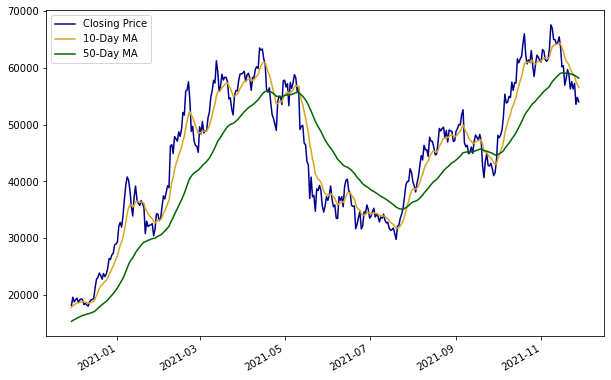

In [16]:
fig, ax = plt.subplots(figsize=(10, 6)) 

cutoff_date2 = dt.datetime.today() - dt.timedelta(days=365) 
last_365_days = btc[btc.Date >= cutoff_date2] 

plt.xticks(rotation=30, ha="right") 

ax.plot(last_365_days.Date, last_365_days.Close, color='darkblue', label='Closing Price')
ax.plot(last_365_days.Date, last_365_days.EMA_10_day, color='goldenrod', label='10-Day MA') 
ax.plot(last_365_days.Date, last_365_days.EMA_50_day, color='darkgreen', label='50-Day MA') 

plt.legend(); 

#### 18-MONTH CHART - CURRENT

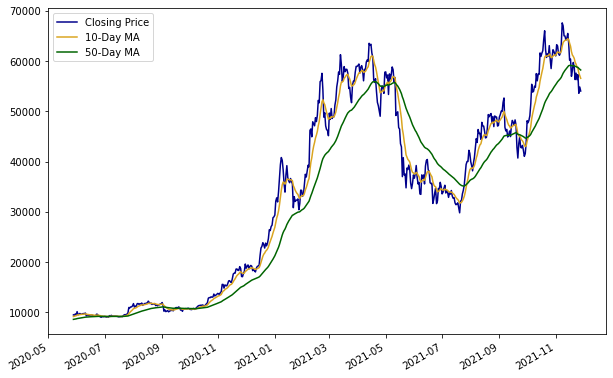

In [32]:
fig, ax = plt.subplots(figsize=(10, 6)) 

cutoff_date3 = dt.datetime.today() - dt.timedelta(days=550) 
last_550_days = btc[btc.Date >= cutoff_date3] 

plt.xticks(rotation=30, ha="right") 

ax.plot(last_550_days.Date, last_550_days.Close, color='darkblue', label='Closing Price')
ax.plot(last_550_days.Date, last_550_days.EMA_10_day, color='goldenrod', label='10-Day MA') 
ax.plot(last_550_days.Date, last_550_days.EMA_50_day, color='darkgreen', label='50-Day MA') 

plt.legend(); 

#### 12-MONTH CHART - 2018

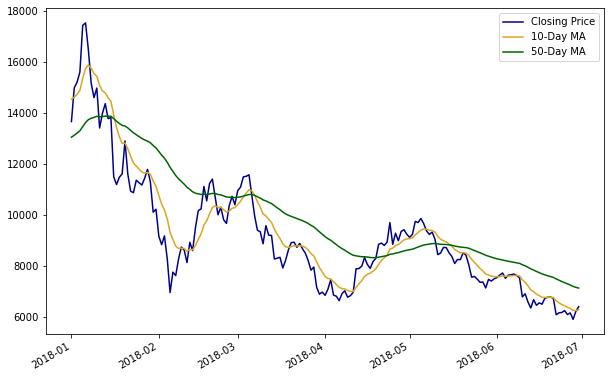

In [33]:
fig, ax = plt.subplots(figsize=(10, 6)) 

cutoff_date3 = '2018-1-1' 
cutoff_date4 = '2018-6-30' 
one_year2018 = btc.loc[(btc.Date >= cutoff_date3) & (btc.Date <= cutoff_date4)] 

plt.xticks(rotation=30, ha="right") 

ax.plot(one_year2018.Date, one_year2018.Close, color='darkblue', label='Closing Price')
ax.plot(one_year2018.Date, one_year2018.EMA_10_day, color='goldenrod', label='10-Day MA') 
ax.plot(one_year2018.Date, one_year2018.EMA_50_day, color='darkgreen', label='50-Day MA') 

plt.legend(); 

#### indications for current status

In [34]:
vol_min1 = .6
vol_max1 = .95
high_ten_day_vol = btc.loc[(btc.Vol10dayPercentile > vol_min1) & (btc.Vol10dayPercentile < vol_max1)]
large_drops1 = high_ten_day_vol[high_ten_day_vol.twenty_day_quartile == 'large_drop']

print('This situation has presented itself:', round(large_drops1.shape[0] / btc.shape[0],3)*100, '% of the time.')

This situation has presented itself: 11.0 % of the time.


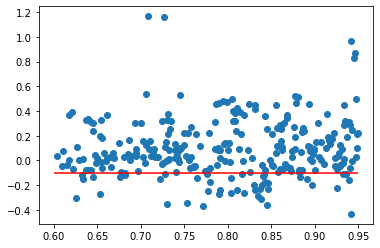

In [35]:
plt.scatter(large_drops1.Vol10dayPercentile, large_drops1.thirty_day_fwd_perc_chng)
plt.hlines(y=-.10, xmin=vol_min1, xmax=vol_max1, color='r');

In [36]:
vol_min2 = .65
vol_max2 = .95
high_thirty_day_vol = btc.loc[(btc.Vol30dayPercentile > vol_min2) & (btc.Vol30dayPercentile < vol_max2)]
large_drops2 = high_thirty_day_vol[high_thirty_day_vol.twenty_day_quartile == 'large_drop']

print('This situation has presented itself:', round(large_drops2.shape[0] / btc.shape[0],3)*100, '% of the time.')

This situation has presented itself: 9.700000000000001 % of the time.


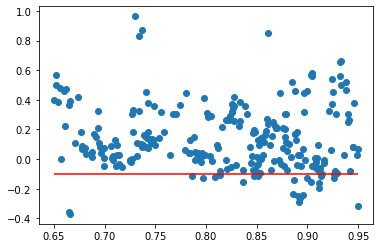

In [37]:
plt.scatter(large_drops2.Vol30dayPercentile, large_drops2.thirty_day_fwd_perc_chng)
plt.hlines(y=-.10, xmin=vol_min2, xmax=vol_max2, color='r');

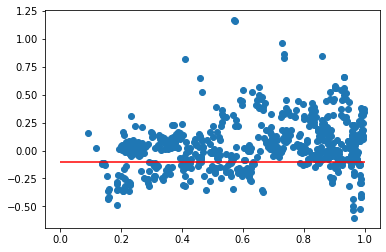

In [38]:
vol_min3 = 0
vol_max3 = 1.0001
high_thirty_day_vol = btc.loc[(btc.Vol30dayPercentile > vol_min3) & (btc.Vol30dayPercentile < vol_max3)]
large_drops3 = high_thirty_day_vol[high_thirty_day_vol.twenty_day_quartile == 'large_drop']

plt.scatter(large_drops3.Vol30dayPercentile, large_drops3.thirty_day_fwd_perc_chng)
plt.hlines(y=-.10, xmin=vol_min3, xmax=vol_max3, color='r'); 

#### Current Status

idea here is to look for situation where:
1. the 20-Day Quartile Category is a 'large drop' 
2. the 10-Day Volatility Percentile is greater than 60% or the 30-Day Volatility Percentile is greater than 65%
3. describe method below shows where the 50th percentile is for 10-day volatility - Vol needs to be materially higher than that figure

In [41]:
btc['Vol10day'].describe()

count    2628.000000
mean        0.106331
std         0.064295
min         0.005013
25%         0.061707
50%         0.095390
75%         0.133787
max         0.541106
Name: Vol10day, dtype: float64

In [42]:
current = pd.DataFrame({'10-Day % Change': btc.ten_day_perc_chng[btc.index[-1]], 
                        '20-Day % Change': btc.twenty_day_perc_chng[btc.index[-1]], 
                        '20-Day Quartile Category': btc.twenty_day_quartile[btc.index[-1]], 
                        'Distance From 10-Day EMA': btc.dist_10_day_EMA[btc.index[-1]], 
                        'Distance From 10-Day (Abs Value) Percentile': btc.dist_10_day_rank_abs[btc.index[-1]], 
                        'Distance From 50-Day EMA': btc.dist_50_day_EMA[btc.index[-1]],  
                        'Distance From 50-Day (Abs Value) Percentile': btc.dist_50_day_rank_abs[btc.index[-1]], 
                        '52-Week High': btc.fifty_two_wk_high[btc.index[-1]], 
                        'Distance From 52-Week High': btc.dist52_wk_high[btc.index[-1]], 
                        '52-Week Low': btc.fifty_two_wk_low[btc.index[-1]], 
                        'Distance From 52-Week Low': btc.dist52_wk_low[btc.index[-1]], 
                        '10-Day Volatility': btc.Vol10day[btc.index[-1]], 
                        '10-Day Volatility Percentile': btc.Vol10dayPercentile[btc.index[-1]], 
                        '30-Day Volatility': btc.Vol30day[btc.index[-1]], 
                        '30-Day Volatility Percentile': btc.Vol30dayPercentile[btc.index[-1]]}, 
                        index=['Score']) 

current.T 

,Score
10-Day % Change,-0.0513628
20-Day % Change,-0.200533
20-Day Quartile Category,large_drop
Distance From 10-Day EMA,-0.0446859
Distance From 10-Day (Abs Value) Percentile,0.662357
Distance From 50-Day EMA,-0.0718666
Distance From 50-Day (Abs Value) Percentile,0.447529
52-Week High,67566.8
Distance From 52-Week High,0.200533
52-Week Low,18058.9


#### Volatility Calculation

https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/


https://tinytrader.io/how-to-calculate-historical-price-volatility-with-python/

In [54]:
past_year = btc[btc.Date >= dt.datetime(2020, 8, 22)]

Need an automated way to show the graph of similar historical situations